In [1]:
# NumericalDiag.ipynb
# Date: 06/21/2021
# Author: Rio Weil
# Functionality: Numerical Diagonalization for interpolated cluster state Hamiltonian.

# Numerical Diagonalization

We start from the place of having done a Jordan-Wigner transformation on our Hamiltonian, and we now have a Hamiltonian purely written in terms of quadratic fermionic operators which we wish to diagonalize. We make the observation that (in general for quadratic Hamiltonians) this Hamiltonian can be written in the form:

$$
H=\sum_{j k}\left(\alpha_{j k} a_{j}^{\dagger} a_{k}-\alpha_{j k}^{*} a_{j} a_{k}^{\dagger}+\beta_{j k} a_{j} a_{k}-\beta_{j k}^{*} a_{j}^{\dagger} a_{k}^{\dagger}\right)
$$

Hence, we can write this as:

$$
H = \begin{bmatrix}
a_1^\dagger \ldots a_n^\dagger a_1 \ldots a_n
\end{bmatrix}
\begin{bmatrix}
\alpha & -\beta^*
\\ \beta & -\alpha^*
\end{bmatrix}
\begin{bmatrix}
a_1 \\ \vdots \\ a_n \\ a_1^\dagger \\ \vdots \\ a_n^\dagger
\end{bmatrix}
$$
where $\alpha, \beta$ are block matrices; in particular, $\alpha$ is Hermitian and $\beta$ is anti-symmetric. It then suffices to consider the diagonalization of:
$$
\begin{bmatrix}
\alpha & -\beta^*
\\ \beta & -\alpha^*
\end{bmatrix}
$$

The numerical approach is the only feasible one as an analytical Bugolibov transform becomes unfeasible in the open boundary condition case due to the boundary terms. In the periodic case it is exactly solvable, but quantum computation generally makes sense only on the chain and not on the ring, so the chain is more meaningful to study. In addition, the chain with additional boundary terms of $X_1Z_2$ and $Z_{N-1}X_N$ is hopeless as the JW transform of these operators results in non-quadratic fermionic terms arising in the state-space. Hence, we now consider the numerical diagonalization of the open chain.

One potential issue is whether or not the eigenvectors will still obey the fermionic CCRs after the numerical diagonalization (it would seem like unlike an analytical Bugolibov transform, when we just pass the above matrix to numpy to diagonalize, there isn't a guarantee that the eigenvectors would be fermionic). Some discussions on this topic has lead to the conjecture that the special form of the above matrix makes it true that this will be the case. Perhaps some additional discussion/proof to be done here to ensure that this is true.

We now look at the specific problem at hand. Starting with Hamiltonian in spin space, we have
$$
H = -\cos\alpha\sum_{i=2}^{N-1}X_{i-1}Z_iX_{i+1} - \sin\alpha\sum_{i=1}^NZ_i.
$$
After the JW transform into fermionic space, we obtain:
$$
H=-\cos \alpha \sum_{i=2}^{N-1}\left(a_{i-1}^{\dagger} a_{i+1}^{\dagger}+a_{i-1}^{\dagger} a_{i+1}-a_{i-1} a_{i+1}^{\dagger}-a_{i-1} a_{i+1}\right)-\sin \alpha \sum_{i=1}^{N}\left(a_{i} a_{i}^{\dagger}-a_{i}^{\dagger} a_{i}\right)
$$
which does nto quite have the form we require; in particular, we notice that there is no way that the $\alpha, \beta$ we construct will have the hermitian/antisymmetric properties that we need for the correct diagonalization. Hence, we first perform the intermediate step of recognizing that $[a_i^\dagger, a_j] = 0$ (if $i \neq j$) and $[a_i, a_j] = 0$ to rewrite the above Hamiltonian as:

$$
H = -\frac{\cos\alpha}{2}\sum_{i=2}^{N-1}\left(a_{i-1}^{\dagger} a_{i+1}^{\dagger} - a_{i+1}^\dagger a_{i-1}^\dagger +a_{i-1}^{\dagger} a_{i+1} - a_{i+1}a_{i-1}^\dagger -a_{i-1} a_{i+1}^{\dagger} + a_{i+1}^\dagger a_{i-1} -a_{i-1} a_{i+1} + a_{i+1}a_{i-1}\right) \\ -\sin \alpha \sum_{i=1}^{N}\left(a_{i} a_{i}^{\dagger}-a_{i}^{\dagger} a_{i}\right)
$$

By inspection, we can verify that this has the correct form (for $\alpha, \beta$ being Hermitian and antisymmetric, respectively.). We now write a function to construct the $
\begin{bmatrix}
\alpha & -\beta^*
\\ \beta & -\alpha^*
\end{bmatrix}
$
matrix for a chain of length $N$ numerically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from qutip import *
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [4]:
def construct_H(N, alpha, periodic = False):
    """
    Constructs the [\alpha & -\beta^* \\ \beta & -\alpha^*] matrix for the
    interpolated cluster state Hamiltonian in fermionic space.
    N is an odd integer >= 3, length of the chain in spin space.
    alpha is a real number between 0 and pi/2 (inclusive).
          for alpha = 0, we have something like a cluster state (not quite, missing boundary terms)
          for alpha = pi/2, we have a product state.
    """
    matrix = np.zeros((2*N, 2*N))  # Initialize matrix
    
    sine_alpha = np.round(np.sin(alpha), 8)
    cosine_alpha = np.round(np.cos(alpha), 8)
    
    # i = 0 term for product state
    matrix[0][0] = sine_alpha
    matrix[N][N] = -sine_alpha  
    # i = N term for product state
    matrix[N-1][N-1] = sine_alpha
    matrix[2*N-1][2*N-1] = -sine_alpha
    
    if periodic:
        # i = 0 term for cluster state
        matrix[N-1][1] = -cosine_alpha/2     # aN^dagger a2
        matrix[N+1][2*N-1] = cosine_alpha/2  # a2 aN^dagger 
        matrix[2*N-1][N+1] = cosine_alpha/2  # aN a2^dagger
        matrix[1][N-1] = -cosine_alpha/2     # a2^dagger aN
        matrix[N-1][N+1] = -cosine_alpha/2   # aN^dagger a2^dagger
        matrix[1][2*N-1] = cosine_alpha/2    # a2^dagger aN^dagger
        matrix[2*N-1][1] = cosine_alpha/2    # aN a2
        matrix[N+1][N-1] = -cosine_alpha/2   # a2 aN
        
        # i = N term for cluster state
        matrix[N-2][0] = -cosine_alpha/2         # aN-1^dagger a1
        matrix[N][2*N-2] = cosine_alpha/2          # a1 aN-1^dagger
        matrix[2*N-2][N] = cosine_alpha/2          # aN-1 a1^dagger
        matrix[0][N-2] = -cosine_alpha/2         # a1^dagger aN-1
        matrix[N-2][N] = -cosine_alpha/2         # aN-1^dagger a1^dagger
        matrix[0][2*N-2] = cosine_alpha/2          # a1^dagger aN-1^dagger
        matrix[2*N-2][0] = cosine_alpha/2          # aN-1 a1
        matrix[N][N-2] = -cosine_alpha/2         # a1 aN-1
    
    for i in range(1, N-1):  # i = 1 to i = N-1 terms
        # Product state terms
        matrix[i][i] = sine_alpha               # ai^dagger ai
        matrix[i+N][i+N] = -sine_alpha          # ai ai^dagger
        
        # Cluster state terms
        matrix[i-1][i+1] = -cosine_alpha/2      # ai-1^dagger ai+1
        matrix[i+1+N][i-1+N] = cosine_alpha/2   # ai+1 ai-1^dagger
        matrix[i-1+N][i+1+N] = cosine_alpha/2   # ai-1 ai+1^dagger
        matrix[i+1][i-1] = -cosine_alpha/2      # ai+1^dagger ai-1
        matrix[i-1][i+1+N] = -cosine_alpha/2    # ai-1^dagger ai+1^dagger
        matrix[i+1][i-1+N] = cosine_alpha/2     # ai+1^dagger ai-1^dagger
        matrix[i-1+N][i+1] = cosine_alpha/2     # ai-1 ai+1
        matrix[i+1+N][i-1] = -cosine_alpha/2    # ai+1 ai-1
        
    return matrix

In [5]:
def get_GS_energy(eigvals):
    """
    Given an array of eigenvalues/eigenenergies of H, extracts the ground state energy
    This is done by summing over all of the negative eigenvalues.
    eigvals - eigenvalues/eigenenergies of the Hamiltonian
    """
    GS_energy = 0
    for j in range(len(eigvals)):
        if (eigvals[j] < 0):
            GS_energy += eigvals[j]
    return GS_energy


def get_gap(eigvals):
    """
    Return the gap between the GS energy and the energy of the first excited state
    This is done by finding the smallest absolute value eigenenergy.
    This version of the function accounts for the fact that there could be zero eigenvalues,
    and thus it looks for the smallest nonzero eigenvalue to obtain the gap.
    eigvals - eigenvalues/eigenenergies of the Hamiltonian
    """
    gap = 10000
    for e in eigvals:
        temp = np.abs(e)
        if temp > 1e-15 and temp < gap:
            gap = temp
    return gap*2 # times 2 as we choose the positive eigval and not the negative.

In [6]:
def make_plot(N, npoints, gap = False, periodic = False):
    """
    Plots the gap between the GS energy and the energy fo the first excited state
    for the interpolated cluster state Hamiltonian, as a function of alpha.
    npoints will be taken from alpha = 0 to alpha = pi/2
    N is the length of the chain.
    """
    alphas = np.linspace(0, np.pi/2, npoints)
    y_ar = []
    for alpha in alphas:
        H = construct_H(N, alpha, periodic)
        eigvals, eigvecs = np.linalg.eig(H)
        if gap:
            y_ar.append(get_gap(eigvals))
        else:
            y_ar.append(get_GS_energy(eigvals))
    plt.plot(alphas, y_ar, label = "N = " + str(N))

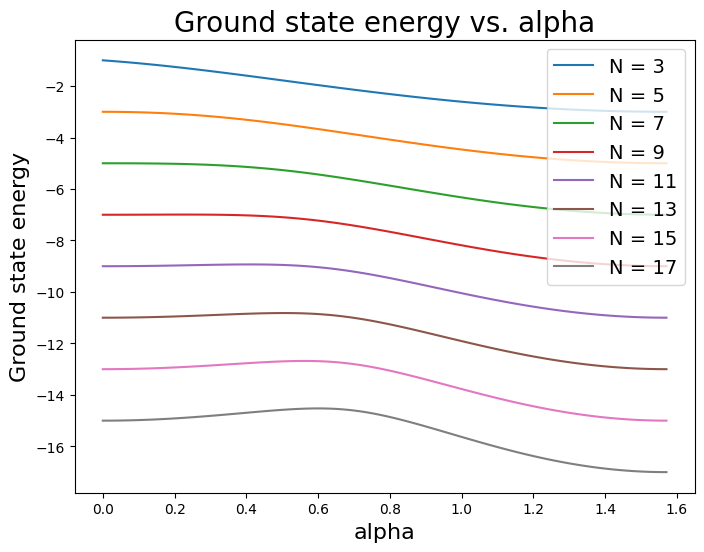

In [7]:
Nar = [3, 5, 7, 9, 11, 13, 15, 17]

for N in Nar:
    make_plot(N, 100)

plt.title("Ground state energy vs. alpha", size = 20)
plt.xlabel("alpha", size = 16)
plt.ylabel("Ground state energy", size = 16)
plt.legend(loc = "best", prop={'size': 14})
#plt.savefig("GSEnergy_alpha_open.pdf")
plt.show()

The above plot makes sense at the boundary values of $\alpha = 0$ and $\alpha = \frac{\pi}{2}$; the ground state of the modified (no endpoint) cluster state hamiltonian commutes with all of the $N - 2$ terms in the Hamiltonian, so we would expect a ground state energy of $N - 2$. Similarly, the ground state of the product state Hamiltonian commutes with all $N$ terms of the Hamiltonian, and we would expect a ground state energy of $N$. This is reflected in the figure.

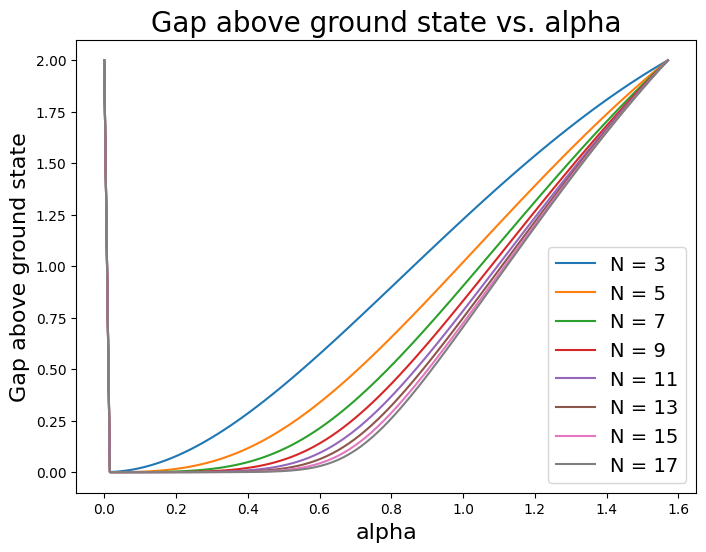

In [8]:
for N in Nar:
    make_plot(N, 100, True)

plt.title("Gap above ground state vs. alpha", size = 20)
plt.xlabel("alpha", size = 16)
plt.ylabel("Gap above ground state", size = 16)
plt.legend(loc = "best", prop={'size': 14})
#plt.savefig("GSGap_alpha_open.pdf")
plt.show()

Again, this looks pretty in-line with what we would expect. At $\alpha = 0$, there is degeneracy in the ground state, so the gap is zero. At $\alpha = \frac{\pi}{2}$, the gap above the product state ground state should be $1$.

In [9]:
# Some checking about the 4-fold degeneracy
eigvals, eigvecs = np.linalg.eig(construct_H(3, 0))
print(np.round(eigvals, 3))
print(np.round(eigvecs, 3))

[-1.  0.  1. -0.  0. -0.]
[[ 0.5    0.707 -0.5    0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.     0.   ]
 [ 0.5   -0.     0.5    0.707  0.     0.   ]
 [-0.5    0.707  0.5    0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]
 [ 0.5   -0.     0.5   -0.707  0.     0.   ]]


We get a 4-fold degeneracy (4 ways of selecting between 2 pairs of zeros), as we would expect. We also check the product state results:

In [10]:
# Does product state look as expected?
eigvals, eigvecs = np.linalg.eig(construct_H(3, np.pi/2))
print(eigvals)
print(eigvecs)

[ 1.  1.  1. -1. -1. -1.]
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


For the periodic case, our Hamiltonian becomes:
$$
H = -\frac{\cos\alpha}{2}\sum_{i=1}^{N}\left(a_{i-1}^{\dagger} a_{i+1}^{\dagger} - a_{i+1}^\dagger a_{i-1}^\dagger +a_{i-1}^{\dagger} a_{i+1} - a_{i+1}a_{i-1}^\dagger -a_{i-1} a_{i+1}^{\dagger} + a_{i+1}^\dagger a_{i-1} -a_{i-1} a_{i+1} + a_{i+1}a_{i-1}\right) \\ -\sin \alpha \sum_{i=1}^{N}\left(a_{i} a_{i}^{\dagger}-a_{i}^{\dagger} a_{i}\right)
$$
where $i = 0$ corresponds to $i = N$ and $i = N+1$ corresponds to $i = 1$. The construction of this matrix (the addition of the extra terms) has been done in the construct_H function above. Let us see what the plots look like in this case. Note that the chain length must be even.

/Users/ryoheiweil/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ryoheiweil/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ryoheiweil/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ryoheiweil/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ryoheiweil/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:102: 

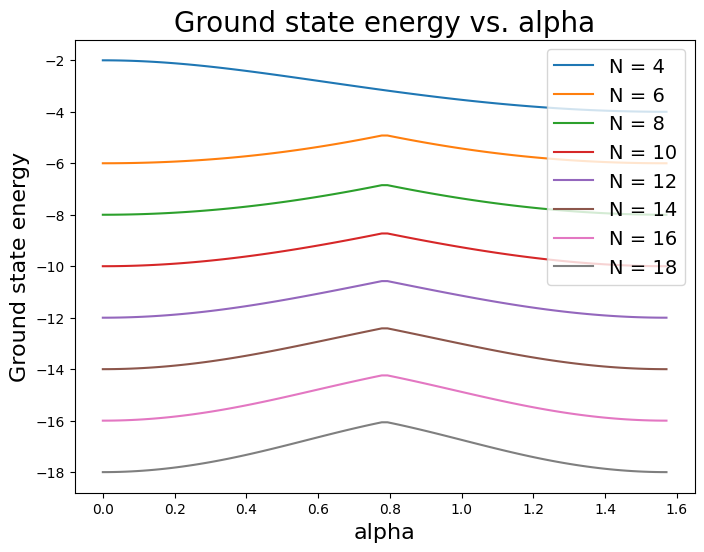

In [11]:
Nar = [4, 6, 8, 10, 12, 14, 16, 18]

for N in Nar:
    make_plot(N, 100, False, True)

plt.title("Ground state energy vs. alpha", size = 20)
plt.xlabel("alpha", size = 16)
plt.ylabel("Ground state energy", size = 16)
plt.legend(loc = "best", prop={'size': 14})
plt.savefig("GSEnergy_alpha_periodic.pdf")
plt.show()

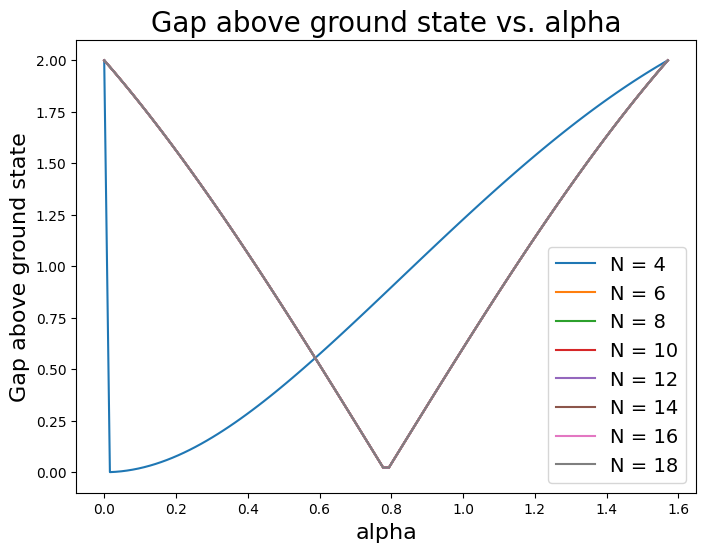

In [12]:
for N in Nar:
    make_plot(N, 100, True, True)

plt.title("Gap above ground state vs. alpha", size = 20)
plt.xlabel("alpha", size = 16)
plt.ylabel("Gap above ground state", size = 16)
plt.legend(loc = "best", prop={'size': 14})
plt.savefig("GSGap_alpha_periodic.pdf")
plt.show()

Some two points of strangeness; the $N = 4$ case is an outlier (it looks like the open BC cases, which is bizarre) and for the rest, the plot is invariant of $N$, when the gap should be decreasing (at $\alpha = \frac{\pi}{4}$) with increasing $N$. Something is clearly going wrong here. Checking the eigenvalues, we have:

In [13]:
H = construct_H(3, 0, True)
#print("N = 3 Hamiltonian")
#print(H)
eigvals, eigvecs = np.linalg.eig(H)
print("Eigvals for N = 3, cluster state")
print(eigvals)

H = construct_H(4, 0, True)
#print("N = 4 Hamiltonian")
#print(H)
eigvals, eigvecs = np.linalg.eig(H)
print("Eigvals for N = 4, cluster state")
print(eigvals)

H = construct_H(5, 0, True)
#print("N = 6 Hamiltonian")
#print(H)
eigvals, eigvecs = np.linalg.eig(H)
print("Eigvals for N = 5, cluster state")
print(eigvals)

H = construct_H(6, 0, True)
eigvals, eigvecs = np.linalg.eig(H)
print("Eigvals for N = 6, cluster state")
print(eigvals)

Eigvals for N = 3, cluster state
[ 1. -1.  1. -1.  1. -1.]
Eigvals for N = 4, cluster state
[-1.00000000e+00  1.00000000e+00 -1.00000000e+00  1.00000000e+00
  5.05964412e-17 -5.71068755e-17  2.95039060e-17 -1.37965849e-33]
Eigvals for N = 5, cluster state
[ 1. -1. -1.  1.  1. -1. -1. -1.  1.  1.]
Eigvals for N = 6, cluster state
[ 1. -1. -1.  1. -1.  1.  1.  1.  1. -1. -1. -1.]


Where we observe $0$ eigenvalues (and hence a degenerate ground state) in the $N = 4$ case but none of the other cases. Strange! Let us also try to diagonalize directly in the spin basis (a tractable calculation for $N = 4$) and see the result:

In [2]:
def make_spin_H4(alpha):
    term1 = qutip.tensor(sigmax(), sigmaz(), qeye(2), sigmaz())
    term2 = qutip.tensor(sigmaz(), sigmax(), sigmaz(), qeye(2))
    term3 = qutip.tensor(qeye(2), sigmaz(), sigmax(), sigmaz())
    term4 = qutip.tensor(sigmaz(), qeye(2), sigmaz(), sigmax())
    prodterm1 = qutip.tensor(sigmax(), qeye(2), qeye(2), qeye(2))
    prodterm2 = qutip.tensor(qeye(2), sigmax(), qeye(2), qeye(2))
    prodterm3 = qutip.tensor(qeye(2), qeye(2), sigmax(), qeye(2))
    prodterm4 = qutip.tensor(qeye(2), qeye(2), qeye(2), sigmax())
    
    H = -1*np.cos(alpha)*(term1 + term2 + term3 + term4) - np.sin(alpha) * (prodterm1 + prodterm2 + prodterm3 + prodterm4)
    return H

def get_gap_spin(eigvals):
    """
    Return the gap between the GS energy and the energy of the first excited state
    This is done by finding the smallest absolute value eigenenergy.
    This version of the function accounts for the fact that there could be zero eigenvalues,
    and thus it looks for the smallest nonzero eigenvalue to obtain the gap.
    eigvals - eigenvalues/eigenenergies of the Hamiltonian
    """
    gap = 10000
    neweigvals = list(np.copy(eigvals))
    minval = min(eigvals)
    neweigvals.remove(minval)
    nextminval = min(neweigvals)
    return nextminval - minval
    

In [30]:
alphas = np.linspace(0, np.pi/2, 100)
y_ar = []
for alpha in alphas:
    H = make_spin_H4(alpha)
    eigvals, eigvecs = np.linalg.eig(H)
    y_ar.append(get_gap_spin(eigvals))

/Users/ryoheiweil/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


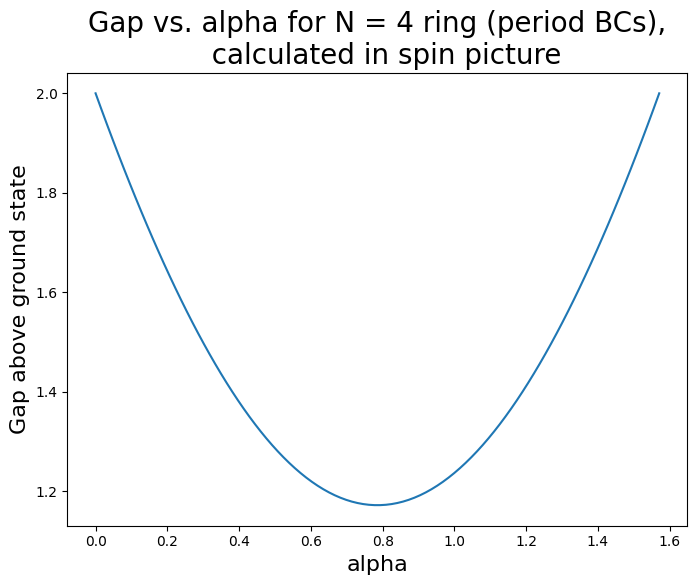

In [35]:
plt.plot(alphas, y_ar)
plt.title("Gap vs. alpha for N = 4 ring (period BCs),\n  calculated in spin picture", size = 20)
plt.xlabel("alpha", size = 16)
plt.ylabel("Gap above ground state", size = 16)
plt.savefig("Gap_4chain_spincalc.pdf")
plt.show()

In [5]:
H = make_spin_H4(0)
eigvals, eigvecs = np.linalg.eig(H)
print(0)
print(np.round(eigvals, 3))

H = make_spin_H4(np.pi/6)
eigvals, eigvecs = np.linalg.eig(H)
print("pi/6")
print(np.round(eigvals, 3))

H = make_spin_H4(np.pi/4)
eigvals, eigvecs = np.linalg.eig(H)
print("pi/4")
print(np.round(eigvals, 3))

H = make_spin_H4(np.pi/2)
eigvals, eigvecs = np.linalg.eig(H)
print("pi/2")
print(np.round(eigvals, 3))

0
[-4.-0.j  4.+0.j -2.+0.j  2.+0.j  2.-0.j -2.-0.j  2.+0.j -2.-0.j -0.+0.j
  0.+0.j  0.-0.j  2.+0.j -0.-0.j -2.+0.j  0.+0.j  0.-0.j]
pi/6
[ 4.   -0.j  2.732+0.j -4.   -0.j -2.732-0.j -2.732+0.j  2.732+0.j
  0.732-0.j -0.   +0.j  0.   -0.j -0.732-0.j  0.732+0.j -0.732-0.j
  0.   +0.j -0.   +0.j  0.   -0.j -0.   -0.j]
pi/4
[-4.   +0.j  0.   +0.j  4.   +0.j  2.828+0.j -2.828+0.j -2.828+0.j
  2.828+0.j  0.   -0.j -0.   +0.j -0.   -0.j -0.   +0.j  0.   +0.j
  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j]
pi/2
[-4.-0.j  4.+0.j -2.+0.j  2.+0.j  2.-0.j -2.-0.j  2.+0.j -2.-0.j -0.+0.j
  0.+0.j  0.-0.j  2.+0.j -0.-0.j -2.+0.j  0.+0.j  0.-0.j]


In [13]:


def getH(alpha):
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0, -1]])
    H_n = (-np.cos(alpha)*(
           np.kron(sX,np.kron(sZ, np.kron(sX, np.eye(2) )))
          +np.kron(np.eye(2),np.kron(sX, np.kron(sZ, sX )))
          +np.kron(sX,np.kron(np.eye(2), np.kron(sX, sZ )))
          +np.kron(sZ,np.kron(sX, np.kron(np.eye(2), sX )))
          )
          -np.sin(alpha)*(
           np.kron(sX,np.kron(np.eye(2), np.kron(np.eye(2), np.eye(2) )))
          +np.kron(np.eye(2),np.kron(sX, np.kron(np.eye(2), np.eye(2) )))
          +np.kron(np.eye(2),np.kron(np.eye(2), np.kron(sX, np.eye(2) )))
          +np.kron(np.eye(2),np.kron(np.eye(2), np.kron(np.eye(2), sX )))
          ))
    return H_n

In [17]:
eigvals, eigvecs = np.linalg.eig(getH(np.pi/4))
print(np.round(eigvals, 5))

[-4.+0.j  4.+0.j  2.+0.j  0.+0.j -2.+0.j -2.+0.j -0.+0.j  2.+0.j  2.+0.j
  2.+0.j -0.+0.j -0.-0.j -2.+0.j -2.+0.j  0.+0.j  0.-0.j]


In [22]:
print(make_spin_H4(0))
print(getH(0))
print(make_spin_H4(np.pi/4))
print(getH(np.pi/4))

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0. -1. -1.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  